Name: Nathan Dang

Partner: Charlie Poff-Webster

Date: 04/28/2020

DSCI225 - Applied Machine Learning

Instructor: Prof. Basye

# Lab 8 - Transfer Learning with Autoencoders

### Prompt:

Examine the notebook for Chapter 11, 11_training_deep_neural_networks.ipynb. You also might want to look at the notebook for chapter 10, which you've already used in lab 6.

Examine the notebook for Chapter 17, 17_autoencoders_and_gans.ipynb.

Build a new notebook for this lab. Much of the contents will probably be cut-and-paste from two chapter notebooks, 11 and 17 - that's OK. If you borrow chunks from anywhere other than the book's notebooks, be sure to document that with a link to where the code came from.

Our goal here is to explore the idea of using an autoencoder as a training aid to allow us to use much less labeled training data. To create a benchmark, use the code from chapter 11 that trains a model for MNIST fashion. Find a model and hyperparameters that do a decent job, but you don't have to spend a lot of time here.

See what happens as you reduce the amount of training data. From whatever amount you started with, reduce it by half repeatedly until you get below 100 images in your training set. Record the resulting accuracy for each amount. Since the runs on smaller amounts will be faster, you can run them for more epochs if it helps. Or just use an early stopping callback and let it run until it stops.

Now train an autoencoder following the notebook for Ch. 17 and then transfer the encoder layers into a new network that does classification. Note that so far, we haven't used any labelled data at all! Now repeatedly train just the upper layer of the classifier on the same amounts of labeled data that you used in the previous step. See section on Using Pretrained Layers in the notebook for Ch. 11 for how to "freeze" the lower layers. Optionally try unfreezing some or all of them and see what that does, too.

In addition, you should also keep progress notes, which will become part of your submission. At the bottom of your notebook, make a single text cell for these notes. Your notes should include two kinds of entries: problems and investigations. Problem entries should read like this: "I (or We) had <problem> in the cell that did <something>. I/We fixed this by <remedy>." Investigation entries should read like this: "I/We didn't understand <something>. We found an explanation at <link> (or perhaps, we talked to <person>) and now I/We understand it."

You may add other kinds of progress entries as you see fit, e.g. "I figured out a clever way to do <something>." But you should have at least 5 problem and 5 investigation entries.
    
<b>NOTE:</b> we marked checkpoints throughout our process which can be seen by the label of a progress log (i.e. "Progress Log 1," "Progress Log 2," etc) followed by a summary of what was going on on each checkpoint. The full documentation of the log can be found at the end of the notebook. 

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Get the data

For this lab, we are asked to use the Fashion MNIST dataset from keras.

Download the dataset.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_train_full.dtype

dtype('uint8')

Split the full training set to validation and training sets, then scale the data by diving all entries by 255.

In [5]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
X_valid.shape

(5000, 28, 28)

In [7]:
X_test.shape

(10000, 28, 28)

Some visualisation of a sample of the images in the dataset.

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

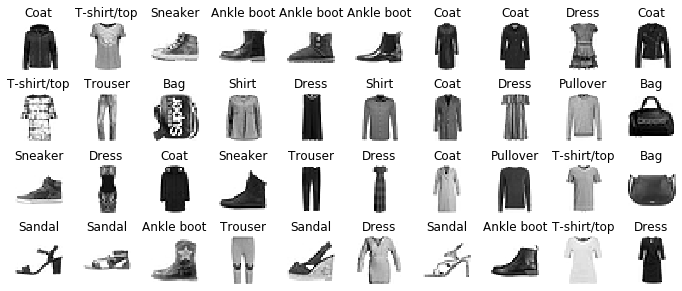

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Train a model

Train a neural network on Fashion MNIST using the ReLU activation function and Batch Normalisation:

In [10]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Progress Log 1

We defined a method that would build a model with 2 hidden 300-neuron layers, with a fixed learning rate of 2e-3. The model used Batch Normalisation and ReLU activation function.

In [11]:
def build_model(n_hidden=2, n_neurons=300, learning_rate=2e-3, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", use_bias=False))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=["accuracy"])
    return model

In [12]:
model = build_model()

In [13]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 8s 152us/sample - loss: 0.6733 - accuracy: 0.7674 - val_loss: 0.4688 - val_accuracy: 0.8400
Epoch 2/30
55000/55000 [==============================] - 7s 135us/sample - loss: 0.4723 - accuracy: 0.8330 - val_loss: 0.4133 - val_accuracy: 0.8612
Epoch 3/30
55000/55000 [==============================] - 8s 141us/sample - loss: 0.4308 - accuracy: 0.8474 - val_loss: 0.3897 - val_accuracy: 0.8678
Epoch 4/30
55000/55000 [==============================] - 8s 141us/sample - loss: 0.4045 - accuracy: 0.8572 - val_loss: 0.3740 - val_accuracy: 0.8688
Epoch 5/30
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3813 - accuracy: 0.8654 - val_loss: 0.3656 - val_accuracy: 0.8692
Epoch 6/30
55000/55000 [==============================] - 8s 141us/sample - loss: 0.3651 - accuracy: 0.8687 - val_loss: 0.3562 - val_accuracy: 0.8756
Epoch 7/30
55000/55000 [===========================

In [14]:
result = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 52us/sample - loss: 0.3415 - accuracy: 0.8814


### Progress Log 2

At this point, we were asked to reduce the amount of training data by half repeatedly until the size of the set got below 100 images. The resulting accuracy for each training amount was also recorded. 

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
accuracy_record = [] # initialise the array
accuracy_record.append(result[1]) # add the accuracy score above to the array

In [17]:
# initialise the halved training set
X_train_halved = X_train[:round(len(X_train)/2)]
y_train_halved = y_train[:round(len(y_train)/2)]

In [18]:
X_train_halved.shape

(27500, 28, 28)

The following method will train and evaluate the model on each halved training set until the length of the set gets bellow 100 images. The method returns the size of the final halved traning set as it will be needed for the next steps.

In [19]:
def testModels(X_train_halved, y_train_halved, epochNumber, i=1):
    while len(X_train_halved) > 100:
        model = build_model()
        # train and evaluate the current model
        print("\nTest #" + str(i) + "\nTraning set size = " + str(len(X_train_halved)) +  "\n")
        history = model.fit(X_train_halved, y_train_halved, epochs=epochNumber,
                        validation_data=(X_valid, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)])
        result = model.evaluate(X_test, y_test)
        print("\n-----------------------------------------------------------------------------------------------------")
        # update the training set
        X_train_halved = X_train_halved[:round(len(X_train_halved)/2)]
        y_train_halved = y_train_halved[:round(len(y_train_halved)/2)]
        # attached the accuracy score to the array
        accuracy_record.append(result[1])
        i += 1
    return len(X_train_halved)

In [20]:
# reset the model
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
epochs = 30;
previous_size = testModels(X_train_halved, y_train_halved, 30)


Test #1
Traning set size = 27500

Train on 27500 samples, validate on 5000 samples
Epoch 1/30
27500/27500 [==============================] - 5s 183us/sample - loss: 0.7985 - accuracy: 0.7287 - val_loss: 0.5373 - val_accuracy: 0.8198
Epoch 2/30
27500/27500 [==============================] - 4s 151us/sample - loss: 0.5379 - accuracy: 0.8092 - val_loss: 0.4703 - val_accuracy: 0.8388
Epoch 3/30
27500/27500 [==============================] - 4s 146us/sample - loss: 0.4747 - accuracy: 0.8321 - val_loss: 0.4355 - val_accuracy: 0.8502
Epoch 4/30
27500/27500 [==============================] - 4s 147us/sample - loss: 0.4404 - accuracy: 0.8438 - val_loss: 0.4195 - val_accuracy: 0.8560
Epoch 5/30
27500/27500 [==============================] - 4s 147us/sample - loss: 0.4212 - accuracy: 0.8526 - val_loss: 0.4074 - val_accuracy: 0.8576
Epoch 6/30
27500/27500 [==============================] - 4s 147us/sample - loss: 0.3996 - accuracy: 0.8560 - val_loss: 0.3980 - val_accuracy: 0.8590
Epoch 7/30
27500

Epoch 23/30
13750/13750 [==============================] - 2s 156us/sample - loss: 0.2674 - accuracy: 0.9077 - val_loss: 0.3854 - val_accuracy: 0.8674
Epoch 24/30
13750/13750 [==============================] - 2s 155us/sample - loss: 0.2644 - accuracy: 0.9094 - val_loss: 0.3854 - val_accuracy: 0.8682
Epoch 25/30
13750/13750 [==============================] - 2s 155us/sample - loss: 0.2584 - accuracy: 0.9115 - val_loss: 0.3858 - val_accuracy: 0.8688
Epoch 26/30
13750/13750 [==============================] - 2s 155us/sample - loss: 0.2594 - accuracy: 0.9087 - val_loss: 0.3831 - val_accuracy: 0.8684
Epoch 27/30
13750/13750 [==============================] - 2s 155us/sample - loss: 0.2462 - accuracy: 0.9136 - val_loss: 0.3832 - val_accuracy: 0.8710
Epoch 28/30
13750/13750 [==============================] - 2s 156us/sample - loss: 0.2433 - accuracy: 0.9156 - val_loss: 0.3848 - val_accuracy: 0.8700
Epoch 29/30
13750/13750 [==============================] - 2s 157us/sample - loss: 0.2405 - ac

3438/3438 [==============================] - 1s 209us/sample - loss: 0.3673 - accuracy: 0.8697 - val_loss: 0.5234 - val_accuracy: 0.8218
Epoch 15/30
3438/3438 [==============================] - 1s 211us/sample - loss: 0.3515 - accuracy: 0.8816 - val_loss: 0.5153 - val_accuracy: 0.8250
Epoch 16/30
3438/3438 [==============================] - 1s 209us/sample - loss: 0.3454 - accuracy: 0.8831 - val_loss: 0.5116 - val_accuracy: 0.8248
Epoch 17/30
3438/3438 [==============================] - 1s 207us/sample - loss: 0.3404 - accuracy: 0.8866 - val_loss: 0.5138 - val_accuracy: 0.8258
Epoch 18/30
3438/3438 [==============================] - 1s 214us/sample - loss: 0.3250 - accuracy: 0.8874 - val_loss: 0.5095 - val_accuracy: 0.8290
Epoch 19/30
3438/3438 [==============================] - 1s 215us/sample - loss: 0.3125 - accuracy: 0.8988 - val_loss: 0.5065 - val_accuracy: 0.8274
Epoch 20/30
3438/3438 [==============================] - 1s 223us/sample - loss: 0.3026 - accuracy: 0.9034 - val_loss:

860/860 [==============================] - 0s 495us/sample - loss: 0.8417 - accuracy: 0.7256 - val_loss: 1.3794 - val_accuracy: 0.6740
Epoch 6/30
860/860 [==============================] - 0s 472us/sample - loss: 0.7683 - accuracy: 0.7593 - val_loss: 1.2113 - val_accuracy: 0.6934
Epoch 7/30
860/860 [==============================] - 0s 474us/sample - loss: 0.7249 - accuracy: 0.7686 - val_loss: 1.0733 - val_accuracy: 0.7100
Epoch 8/30
860/860 [==============================] - 0s 492us/sample - loss: 0.6597 - accuracy: 0.7802 - val_loss: 0.9664 - val_accuracy: 0.7210
Epoch 9/30
860/860 [==============================] - 0s 464us/sample - loss: 0.6130 - accuracy: 0.8151 - val_loss: 0.8834 - val_accuracy: 0.7310
Epoch 10/30
860/860 [==============================] - 0s 474us/sample - loss: 0.5955 - accuracy: 0.8267 - val_loss: 0.8209 - val_accuracy: 0.7430
Epoch 11/30
860/860 [==============================] - 0s 491us/sample - loss: 0.5521 - accuracy: 0.8337 - val_loss: 0.7759 - val_accu

430/430 [==============================] - 0s 823us/sample - loss: 0.3108 - accuracy: 0.9349 - val_loss: 0.7503 - val_accuracy: 0.7574
Epoch 30/30
10000/10000 [==============================] - 1s 50us/sample - loss: 0.7733 - accuracy: 0.7384

-----------------------------------------------------------------------------------------------------

Test #8
Traning set size = 215

Train on 215 samples, validate on 5000 samples
Epoch 1/30
215/215 [==============================] - 1s 6ms/sample - loss: 2.7502 - accuracy: 0.1302 - val_loss: 2.2930 - val_accuracy: 0.1160
Epoch 2/30
215/215 [==============================] - 0s 2ms/sample - loss: 2.1247 - accuracy: 0.2837 - val_loss: 2.2340 - val_accuracy: 0.1468
Epoch 3/30
215/215 [==============================] - 0s 1ms/sample - loss: 1.6941 - accuracy: 0.4140 - val_loss: 2.1799 - val_accuracy: 0.1888
Epoch 4/30
215/215 [==============================] - 0s 1ms/sample - loss: 1.4645 - accuracy: 0.5302 - val_loss: 2.1308 - val_accuracy: 0.233

Epoch 22/30
108/108 [==============================] - 0s 4ms/sample - loss: 0.3618 - accuracy: 0.9537 - val_loss: 1.7838 - val_accuracy: 0.5134
Epoch 23/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.3868 - accuracy: 0.9167 - val_loss: 1.7639 - val_accuracy: 0.5160
Epoch 24/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.3536 - accuracy: 0.9537 - val_loss: 1.7425 - val_accuracy: 0.5220
Epoch 25/30
108/108 [==============================] - 0s 4ms/sample - loss: 0.3300 - accuracy: 0.9352 - val_loss: 1.7225 - val_accuracy: 0.5234
Epoch 26/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.2659 - accuracy: 0.9722 - val_loss: 1.7040 - val_accuracy: 0.5266
Epoch 27/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.2895 - accuracy: 0.9537 - val_loss: 1.6845 - val_accuracy: 0.5304
Epoch 28/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.2990 - accuracy: 0.9537 - val_loss: 1.6642 - val_ac

### Progress Log 3

At the step, we had a quick examination of the accuracy scores as the training got halved until its size was less than 100.

The accuracy scores of all training attemps are as follow:

In [22]:
accuracy_record

[0.8814, 0.8686, 0.8559, 0.8405, 0.8248, 0.8039, 0.7676, 0.7384, 0.644, 0.5196]

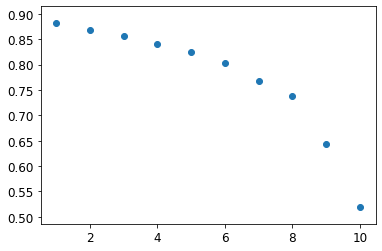

In [23]:
# simple plot to show the decrease in accuracy after each split of the training data
plt.scatter([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], accuracy_record)
plt.show()

Prepare the new training set for the next steps

In [24]:
X_train_halved_final = X_train[:previous_size]
y_train_halved_final = y_train[:previous_size]

In [25]:
X_train_halved_final.shape

(54, 28, 28)

## Train a Convolutional Autoencoder

### Progress Log 4

At the point, we trained a convulutional autoencoder. Initially, the autoencoder will be trained on the full training set leaving out the labels y_train and y_valid (i.e. train the encoder on unlabelled data), just like what we were expected to do.

Define a method to plot the image of a given data point.

In [26]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

Define the image that will show the reconstruction of an image.

In [27]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Define an image for rounded accuracy using keras.

In [28]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Build and train the autoencoder.

### Progress Log 5

At this point, we picked one of the auto encoders from the chapter 17 notebook for this lab. We did skim through all types of auto encoders that the book provided, and we ultimately we chose the convolutional one as the book mentioned that it's good for dealing with image data.

In [29]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["accuracy"])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 52s 948us/sample - loss: 0.3021 - accuracy: 0.5059 - val_loss: 0.2755 - val_accuracy: 0.5111
Epoch 2/5
55000/55000 [==============================] - 52s 942us/sample - loss: 0.2760 - accuracy: 0.5082 - val_loss: 0.2693 - val_accuracy: 0.5118
Epoch 3/5
55000/55000 [==============================] - 52s 939us/sample - loss: 0.2712 - accuracy: 0.5086 - val_loss: 0.2660 - val_accuracy: 0.5121
Epoch 4/5
55000/55000 [==============================] - 52s 936us/sample - loss: 0.2685 - accuracy: 0.5088 - val_loss: 0.2648 - val_accuracy: 0.5124
Epoch 5/5
55000/55000 [==============================] - 51s 935us/sample - loss: 0.2668 - accuracy: 0.5089 - val_loss: 0.2631 - val_accuracy: 0.5124


The summary of the encoder and decoder.

In [31]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

Some visualisation of the reconstructions of some images.

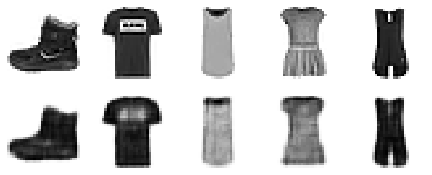

In [32]:
show_reconstructions(conv_ae)
plt.show()

## Train a regular classifier

### Progress Log 6

At this point, we decided to train a classifer on the final halved data set whose size at this point was just 58 images. The model for the classifier was actually the same as those that we used for the previous step. It was created by the build_model() method that we defined earlier.

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
classifier = build_model()

Train the regular classifier.

In [35]:
history = classifier.fit(X_train_halved_final, y_train_halved_final, epochs=100, 
                         validation_data=[X_valid, y_valid], 
                         callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)])

Train on 54 samples, validate on 5000 samples
Epoch 1/100
54/54 [==============================] - 1s 26ms/sample - loss: 2.9965 - accuracy: 0.0370 - val_loss: 2.3711 - val_accuracy: 0.1318
Epoch 2/100
54/54 [==============================] - 0s 6ms/sample - loss: 2.6417 - accuracy: 0.0556 - val_loss: 2.3495 - val_accuracy: 0.1336
Epoch 3/100
54/54 [==============================] - 0s 6ms/sample - loss: 2.2660 - accuracy: 0.1852 - val_loss: 2.3293 - val_accuracy: 0.1354
Epoch 4/100
54/54 [==============================] - 0s 6ms/sample - loss: 1.9993 - accuracy: 0.2593 - val_loss: 2.3094 - val_accuracy: 0.1356
Epoch 5/100
54/54 [==============================] - 0s 6ms/sample - loss: 1.6522 - accuracy: 0.3704 - val_loss: 2.2920 - val_accuracy: 0.1366
Epoch 6/100
54/54 [==============================] - 0s 6ms/sample - loss: 1.4445 - accuracy: 0.5556 - val_loss: 2.2771 - val_accuracy: 0.1370
Epoch 7/100
54/54 [==============================] - 0s 6ms/sample - loss: 1.4252 - accuracy: 0

Evaluate the result.

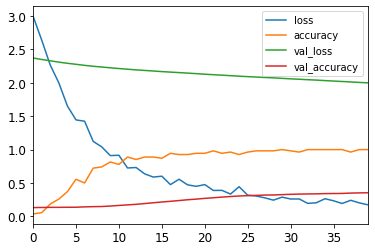

In [36]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [37]:
classifier.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 61us/sample - loss: 2.0011 - accuracy: 0.3461


[2.0010685543060305, 0.3461]

## Transfer the auto encoder layers

### Progress Log 7, 8, 9, 10

This is the last step of our work where we transfered the layers of the encoder into a simple classifier. We pretrained just the layers of the classifier, then we turned on the green light for the autoencoder and trained it along with the classifier. And finally, we compared the result we got with the one above coming from the classifier.

In [38]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
conv_encoder_clone = keras.models.clone_model(conv_encoder)

Define a method for creating a classifier embedded with an autoencoder:

In [40]:
def build_model_ae(auto_encoder, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(auto_encoder)
    model.add(keras.layers.Flatten(input_shape=input_shape))
    keras.layers.Dense(20, activation="relu")
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

In [41]:
pretrained_clf = build_model_ae(conv_encoder_clone)

Pretrain the classifier (i.e. only train the classifying layers)

In [42]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr=0.02),
          metrics=["accuracy"])

In [43]:
history = pretrained_clf.fit(X_train_halved_final, y_train_halved_final, epochs=30,
                             validation_data=[X_valid, y_valid],
                             callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)])

Train on 54 samples, validate on 5000 samples
Epoch 1/30
54/54 [==============================] - 1s 26ms/sample - loss: 2.3962 - accuracy: 0.0556 - val_loss: 2.3625 - val_accuracy: 0.0948
Epoch 2/30
54/54 [==============================] - 1s 18ms/sample - loss: 2.3584 - accuracy: 0.0741 - val_loss: 2.3447 - val_accuracy: 0.0732
Epoch 3/30
54/54 [==============================] - 1s 18ms/sample - loss: 2.3258 - accuracy: 0.0741 - val_loss: 2.3294 - val_accuracy: 0.0880
Epoch 4/30
54/54 [==============================] - 1s 17ms/sample - loss: 2.2968 - accuracy: 0.1481 - val_loss: 2.3162 - val_accuracy: 0.1002
Epoch 5/30
54/54 [==============================] - 1s 17ms/sample - loss: 2.2689 - accuracy: 0.1667 - val_loss: 2.3048 - val_accuracy: 0.1012
Epoch 6/30
54/54 [==============================] - 1s 17ms/sample - loss: 2.2447 - accuracy: 0.1852 - val_loss: 2.2944 - val_accuracy: 0.1068
Epoch 7/30
54/54 [==============================] - 1s 17ms/sample - loss: 2.2262 - accuracy: 0.

Train everything together.

In [44]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr=0.02),
          metrics=["accuracy"])

In [45]:
history = pretrained_clf.fit(X_train_halved_final, y_train_halved_final, epochs=70,
                             validation_data=[X_valid, y_valid],
                             callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)])

Train on 54 samples, validate on 5000 samples
Epoch 1/70
54/54 [==============================] - 1s 27ms/sample - loss: 1.9781 - accuracy: 0.3889 - val_loss: 2.1733 - val_accuracy: 0.2730
Epoch 2/70
54/54 [==============================] - 1s 18ms/sample - loss: 1.9221 - accuracy: 0.4074 - val_loss: 2.1586 - val_accuracy: 0.2988
Epoch 3/70
54/54 [==============================] - 1s 18ms/sample - loss: 1.8672 - accuracy: 0.4259 - val_loss: 2.1311 - val_accuracy: 0.3260
Epoch 4/70
54/54 [==============================] - 1s 18ms/sample - loss: 1.8247 - accuracy: 0.4815 - val_loss: 2.1145 - val_accuracy: 0.3350
Epoch 5/70
54/54 [==============================] - 1s 18ms/sample - loss: 1.7710 - accuracy: 0.5185 - val_loss: 2.1008 - val_accuracy: 0.3362
Epoch 6/70
54/54 [==============================] - 1s 18ms/sample - loss: 1.7285 - accuracy: 0.4815 - val_loss: 2.0579 - val_accuracy: 0.3588
Epoch 7/70
54/54 [==============================] - 1s 19ms/sample - loss: 1.6994 - accuracy: 0.

54/54 [==============================] - 1s 18ms/sample - loss: 0.4265 - accuracy: 0.8519 - val_loss: 1.3081 - val_accuracy: 0.5294
Epoch 58/70
54/54 [==============================] - 1s 18ms/sample - loss: 0.3733 - accuracy: 0.9259 - val_loss: 1.2435 - val_accuracy: 0.5642
Epoch 59/70
54/54 [==============================] - 1s 18ms/sample - loss: 0.3155 - accuracy: 0.9630 - val_loss: 1.2156 - val_accuracy: 0.5704
Epoch 60/70
54/54 [==============================] - 1s 18ms/sample - loss: 0.3164 - accuracy: 0.9630 - val_loss: 1.2978 - val_accuracy: 0.5604
Epoch 61/70
54/54 [==============================] - 1s 18ms/sample - loss: 0.3310 - accuracy: 0.9259 - val_loss: 1.3583 - val_accuracy: 0.5536
Epoch 62/70
54/54 [==============================] - 1s 18ms/sample - loss: 0.3723 - accuracy: 0.8889 - val_loss: 1.1907 - val_accuracy: 0.5928
Epoch 63/70
54/54 [==============================] - 1s 18ms/sample - loss: 0.3300 - accuracy: 0.9259 - val_loss: 1.2573 - val_accuracy: 0.5644
Epoc

Evaluate the result.

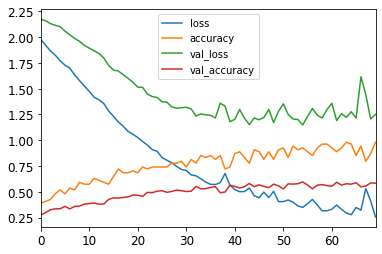

In [46]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [47]:
pretrained_clf.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 192us/sample - loss: 1.2899 - accuracy: 0.5680


[1.289906562423706, 0.568]

## Progress Log

1. We acknowledged that we had to make a bunch of training attempts for some particular steps throughout the lab, and the build_model() method saved us the trouble of having to copy the same chunk of code multiple times. We defined the method based on the one in chapter 10 (under Hyperparameter Tuning section), and at first, we ran into a bit troubles as we received some errors while trying to call the method. Obviously, we could not use the same chunk of code in chapter 10 as we were building a different model; therefore, we had to make some changes to the code. But after staring at it for a while, we figured out the problem, that is, the code in chapter 10 used loss="mse" while we needed to use loss="sparse_categorical_crossentropy" instead. 

2. We defined a method that ran all of the training attemps with different size of the training set, again, to save us the trouble from copying the same block of code over and over again. The accuracy scores throughout the attempts did decrease as the training size was halved on each iteration, exactly like what we expected. After this step, we ended up with a training size of 58 which is obviously less than 100, but we were wondering if this number was too small... 

    Regarding: See what happens as you reduce the amount of training data.

3. It's always satisfying to come to a point in the project where you know you are getting results that make sense. When reducing the amount of training data over these 8 tests it is clear that the accuracy is continuously decreasing. This makes sense given the validation set is staying the same size. This is another interesting way to consider, and prove, the idea that more data is always beneficial in creating a more accurate model. The simple graph below the accuracies, shows a visualization of how the accuracy drops off after each split in half.


4. As the directions only state: "Now train an autoencoder following the notebook for Ch. 17" there is some choice given into what type of autoencoder we can decide to use. Similar to chapter 4, where we have many different types of models to choose from, it's unclear exactly what is the best autoencoder for this dataset. Given we are working with pictures, even if they aren't particularly large images, and are working towards unsupervised pretraining, we decided to first try a convolutional autoencoder. The book says this autoencoder is best at, "dealing with images... convolutional neural networks are far better suited than dense networks to work with images" (pg. 579). From this, we gathered it was the best initial autoencoder to try, and we learned not to make the network too complicated.

    More to come of this in a later log.

5. This was one of the more annoying parts to fiddle around with. Not unsurprisingly, the convolutional autoencoder took a very long time to build and train, with each epoch taking >2 minutes (depending on which computer we were running this on the time obviously varried). We tried changing a few small things like the activation types, the number of layers, and the size of each layer, but none of the tests had a huge impact on how the data changed. What is currently set is the convolutional autoencoder code found from ch17. This had the best results. Mainly, anytime we added another layer or made any of the layers larger the accuracy score went down (although not significantly). While testing this we also noticed (while only running 5 epochs total), that the accuracy hardly improved between epochs. With almost no change, it became easier to test using only one epoch to see if any real change of accuracy occured.

6. At first we thought our autoencoder was doing horribly. Given the autoencoder was taking a long time to build and train, we didn't want to have to try another autoencoder before moving on. Doing this section, training a regular classifier, proved that it wasn't that the autoencoder was doing poorly, it was simply it is difficult for the model to classify a picture at all, whether using the autoencoder or the regular classifier. Similar to step 3, this (poor result) showed that we were actually on the right path. 

7. With only an accuracy score of 0.5031 it seems like we haven't been able to build a great model. At this point we are unsure exactly what we did wrong. Following the logs from above, it is clear that at certian stages of the project we were able to be sure we were on the right path. The main thing we are unsure of at this point is if we chose the wrong autoencoder. Although it seems, from the text, like the convolutional was clearly the right autoencoder for images, we are going to try some other autoencoders to see if it makes any difference.

8. We next tried a variational autoencoder. We chose this autoencoder for a few reasons. As we said above, the convolutional autoencoder took a long time to build and the variational autoencoder "are easier to train, and the sampling process is much faster" (pg. 586). Given that it would be quicker than trying any of the other autoencoders, it also seemed like a good option to try as, although we weren't entirely sure how it worked, the idea of a generative autoencoder seemed like it would work well for classifying images. To our surprise, the outcome was very similar to that of the convolutional autoencoder. It was a bit worse, hitting the 0.4932 accuracy mark, but was surprisingly close. At this point we aren't sure exactly what we are doing wrong.

9. We weren't able to get a very nice accuracy score in the end (~56%), but given the circumstances that makes a lot of sense. Given that we are cutting our dataset in half, many times, it's unsurprising that a smaller dataset won't have as good of an accuracy model. Given that it took a long time to only train on this dataset, it now makes a lot of sense why you wanted us to make the dataset smaller. Ultimately, although the autoencoder didn't have the best accuracy score, it had a significantly better score than a regular network, which we can clearly see when we trained a regular classifier. Hence, the autoencoder is clearly a better method of classifying images on a small dataset. For a larger dataset, it would of course take more time, but there may be more variability in which autoencoder type is best.

10. Final Note: Given that we have split the training data many times to make the dataset smaller, it's unsurprising that in the end we are unable to get a great accuracy score. We did prove the importance of an autoencoder as the regular network had a horrific score in comparison. We did have some thoughts about how we could have improved the accuracy score with the "encoder-classifier model." For starter, the classifier that we put the encoder in was very simple, compared to the one that we used for the first couple steps (i.e. the one with Batch Normalisation and stuff); therefore, we was wondering that if we could have found a more complex model that works better with the encoder, the score would have improved. We did try to combine the encoder with the model that we used the the first couple steps but it turned out that the performance was worse than without the encoder. That was some very bad overfitting right there, so that's why we decided to used a much simpler model to work with the encoder. Also, as mentioned in log #2, the size of the training set that we picked for the encoder was too small, only 58, even the chapter book used the size of 500 which is nearly 10 times bigger than ours; thus, we were thinking that our score could have improved a bit if we used a bit bigger training set (like 99 instead of 58). 